## Load Tools

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report,confusion_matrix

# keras imports
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

## Load the Dataset

In [2]:
# Load the dataset
data = pd.read_csv('train.csv')
data

,VWTI,SWTI,CWTI,EI,Class
0,2.263400,-4.4862,3.65580,-0.612510,0
1,3.271800,1.7837,2.11610,0.613340,0
2,-3.941100,-12.8792,13.05970,-3.312500,1
3,0.519500,-3.2633,3.08950,-0.984900,0
4,2.569800,-4.4076,5.98560,0.078002,0
...,...,...,...,...,...
1091,1.640600,3.5488,1.39640,-0.364240,0
1092,-0.048008,-1.6037,8.47560,0.755580,0
1093,2.942100,7.4101,-0.97709,-0.884060,0
1094,1.964700,6.9383,0.57722,0.663770,0


### About the Data

Data were extracted from images that were taken for the evaluation of an authentication procedure for banknotes. Data were extracted from images that were taken from genuine and forged banknote-like specimens. For digitization, an industrial camera usually used for print inspection was used. The final images have 400x 400 pixels. Due to the object lens and distance to the investigated object grey-scale pictures with a resolution of about 660 dpi were gained. Wavelet Transform tool was used to extract features from images.

### Data Description

VWTI: Variance of Wavelet Transformed Image

SWTI: Skewness of Wavelet Transformed Image

CWTI: Curtosis of Wavelet Transformed Image

EI: Entropy of Image

Class: Class (1: genuine, 0: forged)

## Data Preprocessing

In [3]:
X = data.drop("Class",axis=1)
y = data["Class"]

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Validation Split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

#Scaling
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

y_train = y_train.values
y_val = y_val.values
y_test = y_test.values

# Check shapes
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (700, 4), y_train shape: (700,)
X_val shape: (176, 4), y_val shape: (176,)
X_test shape: (220, 4), y_test shape: (220,)


## Build the ANN Model

In [4]:
X_train.shape[1]

4

In [5]:
# Define the model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),  # Input layer
    Dropout(0.3),  # Dropout to reduce overfitting
    Dense(32, activation='relu'),
    Dropout(0.3),  # Another Dropout layer
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Add early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitors validation loss
    patience=5,          # Stops training after 5 epochs with no improvement
    restore_best_weights=True  # Restores the best model weights
)

# Check model summary
model.summary()

C:\Users\rahul\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,945 (11.50 KB)

 Trainable params: 2,945 (11.50 KB)

 Non-trainable params: 0 (0.00 B)

## Train the Model

In [6]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15,
    batch_size=32,
    callbacks=[early_stopping]  # Use early stopping callback
)

Epoch 1/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.5700 - loss: 0.6686 - val_accuracy: 0.8125 - val_loss: 0.5910
Epoch 2/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7957 - loss: 0.5482 - val_accuracy: 0.8239 - val_loss: 0.4672
Epoch 3/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8371 - loss: 0.4386 - val_accuracy: 0.8580 - val_loss: 0.3450
Epoch 4/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8743 - loss: 0.3251 - val_accuracy: 0.9091 - val_loss: 0.2441
Epoch 5/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9129 - loss: 0.2388 - val_accuracy: 0.9545 - val_loss: 0.1569
Epoch 6/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9457 - loss: 0.1573 - val_accuracy: 0.9659 - val_loss: 0.1028
Epoch 7/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9629 - loss: 0.1106 - val_accuracy: 0.9545 - val_loss: 0.0834
Epoch 8/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9729 - loss: 0.0859 - val_accuracy: 0.9773 - va

## Evaluate the Model

In [7]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9955 - loss: 0.0207 
Test Loss: 0.0207, Test Accuracy: 0.9955


## Generate Evaluation Metrics

In [8]:
# You can also generate predictions
y_pred = (model.predict(X_test) > 0.5).astype(int)


print("Classification Report:")
print(classification_report(y_test, y_pred))

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       135
           1       0.99      1.00      0.99        85

    accuracy                           1.00       220
   macro avg       0.99      1.00      1.00       220
weighted avg       1.00      1.00      1.00       220



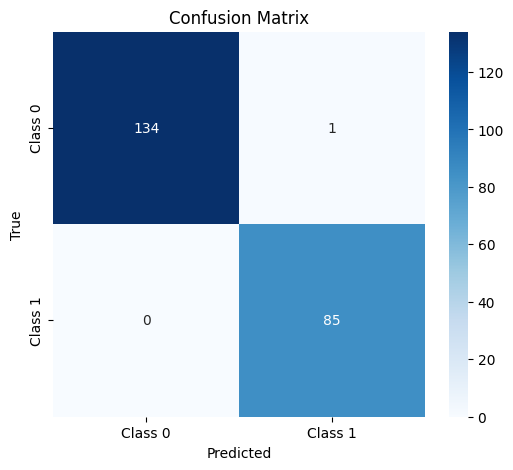

In [9]:
# Plot confusion matrix using seaborn heatmap
import seaborn as sns
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Prediction System

In [10]:
import numpy as np


# Define the make_prediction function
def make_prediction(input_data):
    # Preprocess input data (apply scaling)
    # Use the pre-loaded scaler instead of creating a new one
    input_data_scaled = scaler.transform(input_data)  # Use transform instead of fit_transform
    
    # Use the trained model to predict the class
    predictions = model.predict(input_data_scaled)
    
    # Convert prediction to binary (0 or 1)
    predicted_classes = (predictions > 0.5).astype(int)
    
    # Return the prediction as a string
    if predicted_classes[0] == 1:
        return "Real"
    else:
        return "Fake"

In [11]:
# Example input data for prediction (replace with actual form data or array)
input_data = np.array([[1.5, 2.3, 3.4, 0.7]])  # Example data

# Get the prediction
result = make_prediction(input_data)
print(result)  # Will print "Real" or "Fake" based on the prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Fake


C:\Users\rahul\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [12]:
# Example input data for prediction (replace with actual form data or array)
input_data = np.array([[-3.9411, -12.8792,  13.0597,  -3.3125]])  # Example data

# Get the prediction
result = make_prediction(input_data)
print(result)  # Will print "Real" or "Fake" based on the prediction

C:\Users\rahul\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Real


## Save Model

In [13]:
import pickle

model.save('models/model.h5')
# Save the scaler using pickle
with open('models/scaler.pkl', 'wb') as scaler_file:
    pickle.dump(scaler, scaler_file)